<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Débits-vs-Météo" data-toc-modified-id="Débits-vs-Météo-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Débits vs Météo</a></span></li><li><span><a href="#Fluo" data-toc-modified-id="Fluo-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Fluo</a></span></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates
import datetime

size=40
params = {'legend.fontsize': 'xx-large',
          'figure.titlesize':'xx-large',
          'figure.figsize': (20,15),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

# Constante
g=9.81#m/s2 accélération de la pesanteur
rho=1000#kg/m3 densité eau
dt=15*60 #s 15min en secondes
M=0.539#kg Masse total de colorant

In [2]:
## Import données reefnet
R1=pd.read_csv('Reefnet1.csv') # capteur dans l'eau
R2=pd.read_csv('Reefnet2.csv') # capteur en surface
R1['Date']=pd.to_datetime(R1['Date'], format = '%d/%m/%Y %H:%M:%S')
R2['Date']=pd.to_datetime(R2['Date'], format = '%d/%m/%Y %H:%M:%S')
R1.set_index('Date', inplace = True)
R2.set_index('Date', inplace = True)

#température
t_mean=R2['T (°K)'].rolling(4).mean()-273.15#moyenne glissante sur 4 valeurs

## Calcul Hauteur d'eau
h=(R1['Pressure (mbar)'].values-R2['Pressure (mbar)'].values)*10**2/(g*rho)*10**2 #en cm
d = pd.Series(h)

h_mean=d.rolling(4).mean()#moyenne glissante sur 4 valeurs

## détermination de la fonction f(h)=Q_Résurgence


## Calcul débits GMA
Q_GMA=120.29-14.606*h_mean+0.66381*h_mean**2-0.013292*h_mean**3+0.00009966*h_mean**4 #m3/s 
# loi quadratique représentant le débit en fonction de la hauteur d'eau déterminé par Baudouin Lismonde

## Calcul débits résurgence
Q_R=Q_GMA*0.15 # on considère que la résurgence de la porte de l'enclos représente 15% du débits du Guiers Mort

# On conditionne les données dans un DataFrame
Q=pd.DataFrame({'Date':R1.index,'Hauteur (cm)':h,'Hauteur moyenne (cm)':h_mean, 'Débit GMA (m3/s)':Q_GMA,
                'Débit résurgence (m3/s)':Q_R,'T (°C)':t_mean.values})
Q = Q[~(Q['Date'] < '2022-04-23 14:30:00')]
Q = Q[~(Q['Date'] > '2022-05-01 14:15:00')]
Q.set_index('Date', inplace = True)

m=np.zeros(len(Q.index))
for i in range(len(Q.index)):
    if i==0:
        m[0]=dt*Q['Débit résurgence (m3/s)'].values[i]
    else:
        m[i]=m[i-1]+dt*Q['Débit résurgence (m3/s)'].values[i]
        
Q['Volume eau (m3)']=m

## Débits vs Météo

In [3]:
# import precip
precip=pd.read_csv('precip.csv')
precip['Date']=pd.to_datetime(precip['Date'], format = '%d/%m/%Y %H:%M:%S')
precip.set_index('Date', inplace = True)

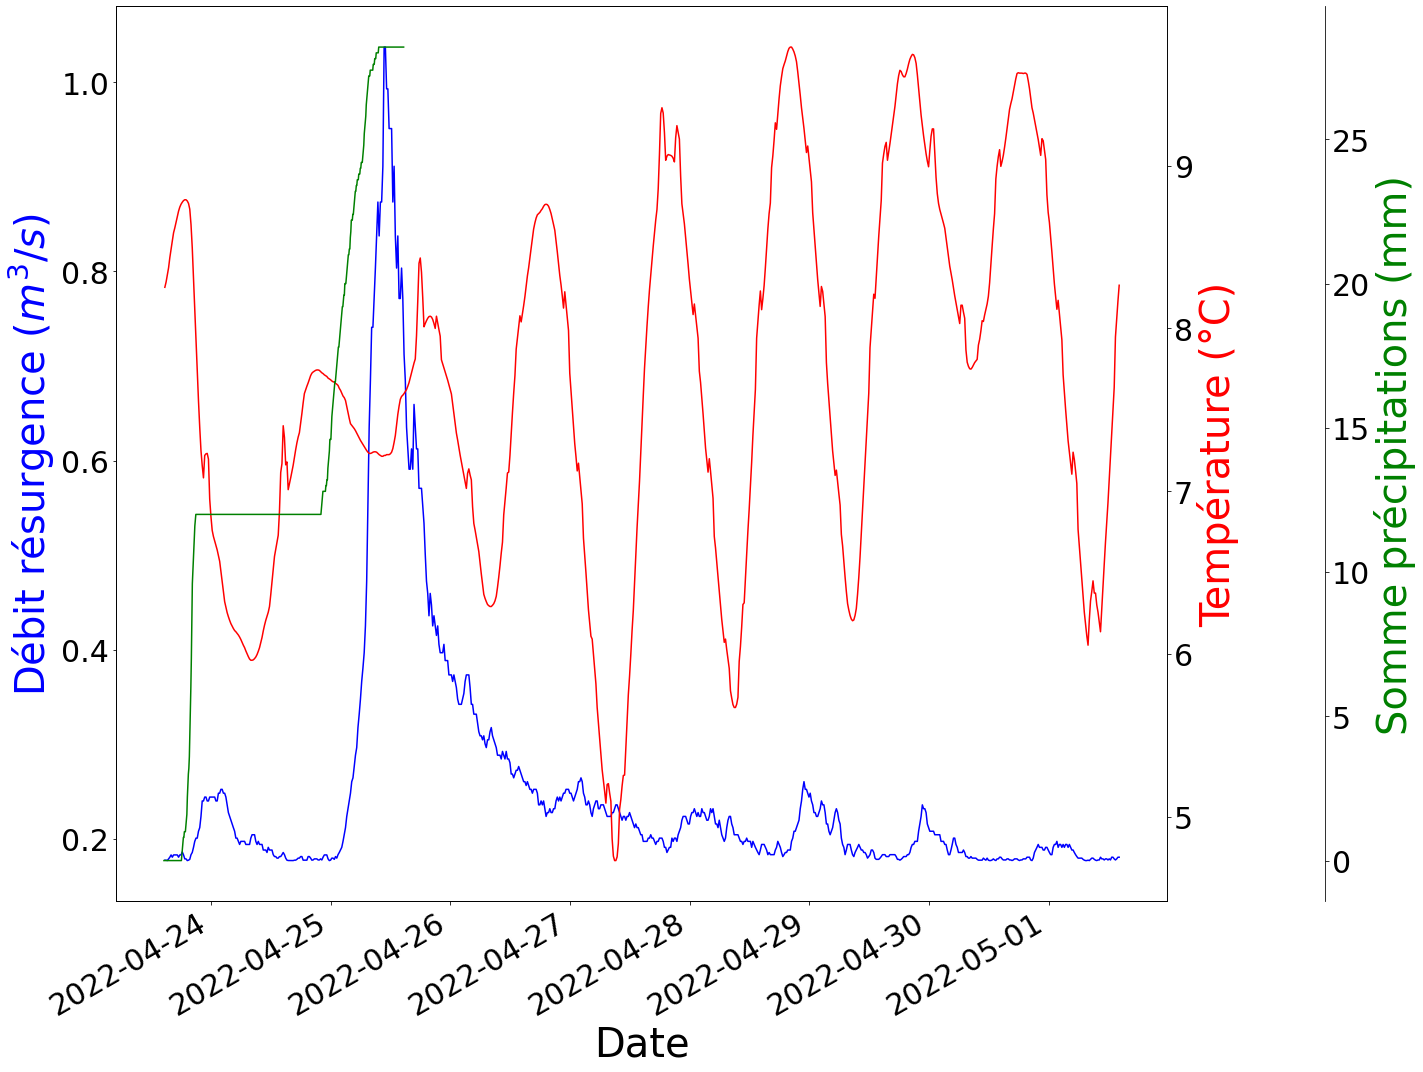

In [4]:
fig=plt.figure()
ax=plt.gca()

ax1=ax.twinx()
ax2=ax.twinx()
ax2.spines.right.set_position(("axes", 1.15))

Q.plot(ax=ax,y="Débit résurgence (m3/s)",c='b',legend=False)
Q.plot(ax=ax1,y="T (°C)",c='r',legend=False)
ax2.plot(precip.index,precip['Sum precip (mm)'],c='g')

ax.yaxis.label.set_color('b')
ax1.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('g')

ax.set_ylabel(r'Débit résurgence ($m^3/s$)')
ax1.set_ylabel(r'Température (°C)')
ax2.set_ylabel(r'Somme précipitations (mm)')

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')

plt.tight_layout()
# plt.savefig('fluo/figure1.jpg')

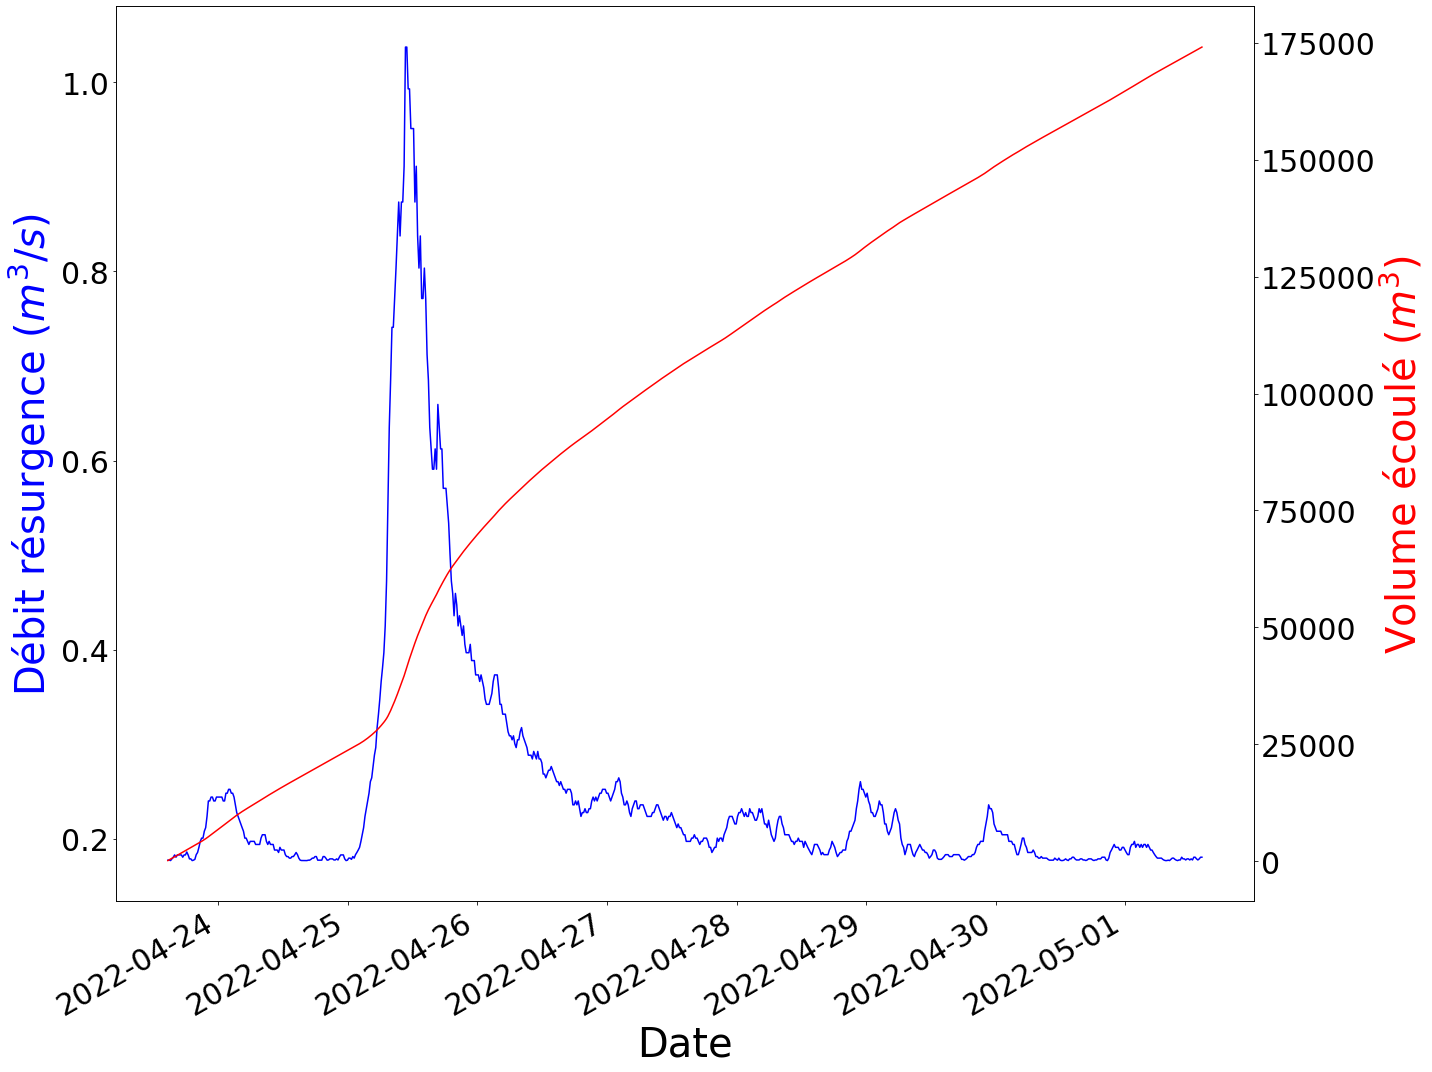

In [5]:
fig=plt.figure()
ax=plt.gca()

ax1=ax.twinx()

Q.plot(ax=ax,y="Débit résurgence (m3/s)",c='b',legend=False)
Q.plot(ax=ax1,y="Volume eau (m3)",c='r',legend=False)

ax.yaxis.label.set_color('b')
ax1.yaxis.label.set_color('r')

ax.set_ylabel(r'Débit résurgence ($m^3/s$)')
ax1.set_ylabel(r'Volume écoulé ($m^3$)')

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')

plt.tight_layout()
plt.savefig('Volume_eau.jpg')

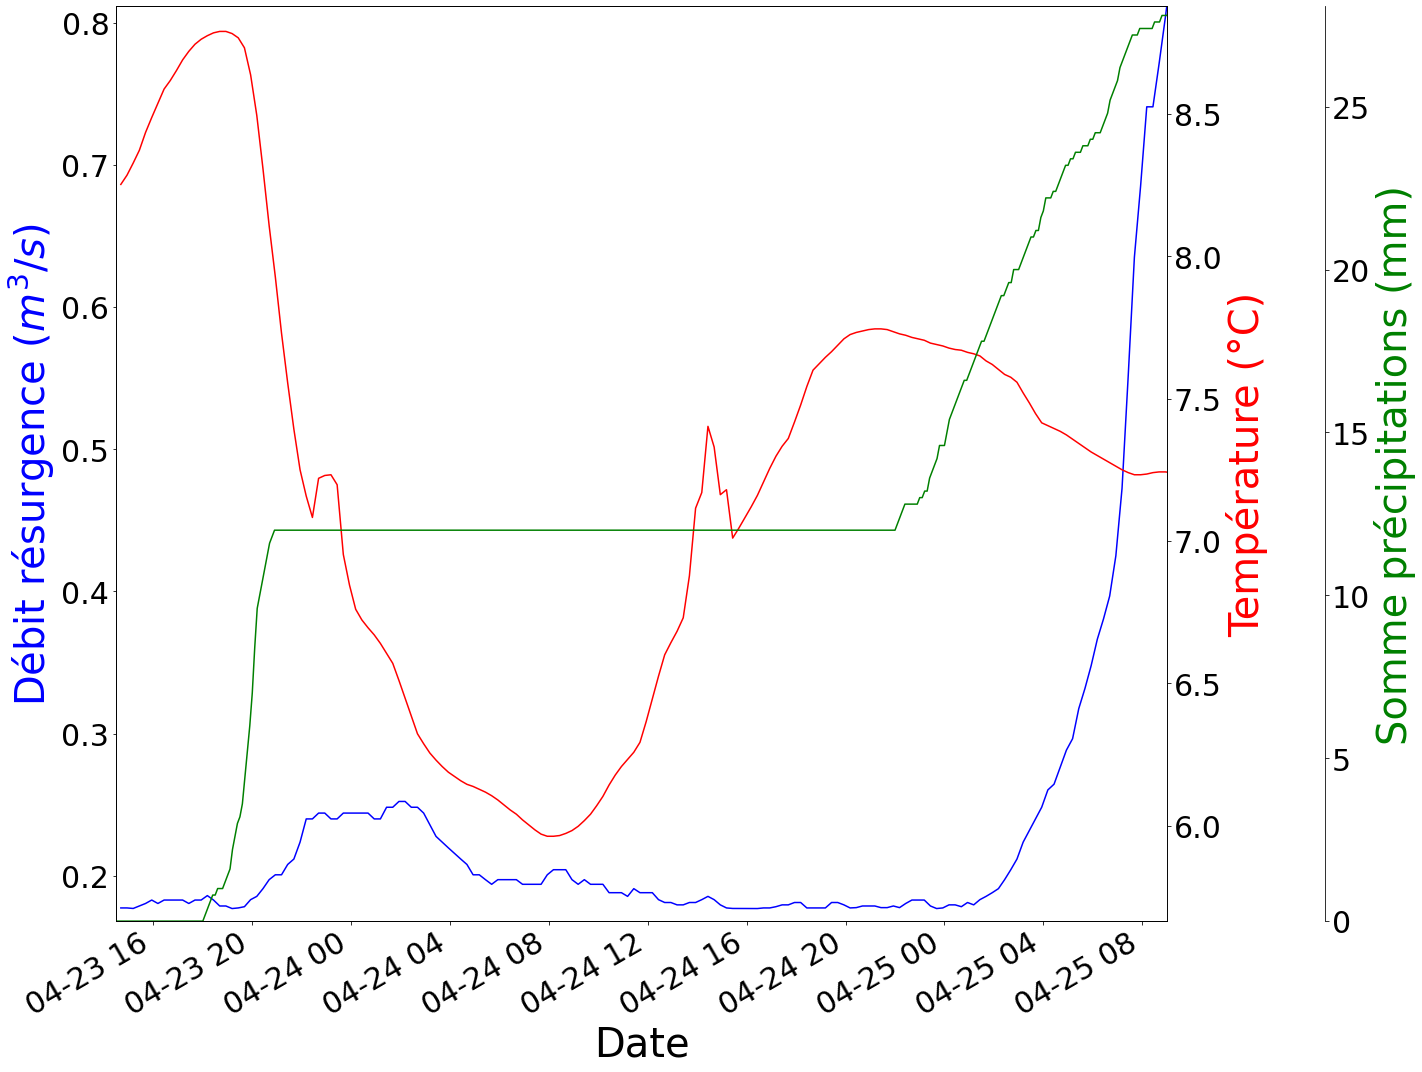

In [6]:
xlim=[datetime.datetime(2022, 4, 23,14,30,0), datetime.datetime(2022, 4,25,9,0,0)]

fig=plt.figure()
ax=plt.gca()

ax1=ax.twinx()
ax2=ax.twinx()
ax2.spines.right.set_position(("axes", 1.15))

Q.plot(ax=ax,y="Débit résurgence (m3/s)",c='b',legend=False)
Q.plot(ax=ax1,y="T (°C)",c='r',legend=False)
ax2.plot(precip.index,precip['Sum precip (mm)'],c='g')

ax.yaxis.label.set_color('b')
ax1.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('g')

ax.set_ylabel(r'Débit résurgence ($m^3/s$)')
ax1.set_ylabel(r'Température (°C)')
ax2.set_ylabel(r'Somme précipitations (mm)')


ax.set_xlim(xlim)
ax.set_ylim( Q[xlim[0]:xlim[1]]['Débit résurgence (m3/s)'].min()*0.95, Q[xlim[0]:xlim[1]]['Débit résurgence (m3/s)'].max()*1.01)
ax1.set_ylim( Q[xlim[0]:xlim[1]]['T (°C)'].min()*0.95, Q[xlim[0]:xlim[1]]['T (°C)'].max()*1.01)
ax2.set_ylim( precip[xlim[0]:xlim[1]]['Sum precip (mm)'].min()*0.95, precip[xlim[0]:xlim[1]]['Sum precip (mm)'].max()*1.01)

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.tight_layout()
# plt.savefig('fluo/figure1_before.jpg')


## Fluo

In [7]:
## import données fluorimètre
F=pd.read_csv('FluoPorteEnclos.csv',skiprows=2)
F['Time']=pd.to_datetime(F['Time'], format = '%y/%m/%d-%H:%M:%S')
F = F[~(F['Time'] < '2022-04-23 14:30:00')][:-4]
F.set_index('Time', inplace = True)

## Calcul concentration
F_ref=9.07 #mV fluometrie de référence
C = 5.405*10**-8 # constante C de la relation d'étalonnage kg/m3

F['Concentration(kg/m3)']=C*(F['Tracer 1']-F_ref)

## calcul masse fluo
xx=np.zeros(len(Q['Débit résurgence (m3/s)'].values))
for i in range(len(Q['Débit résurgence (m3/s)'].values)):
    if i==0:
        xx[0]=Q['Débit résurgence (m3/s)'].values[0]*F['Concentration(kg/m3)'].values[0]*900
    else:
        xx[i]=xx[i-1]+Q['Débit résurgence (m3/s)'].values[i]*F['Concentration(kg/m3)'].values[i]*900
F['Masse (kg)']=xx

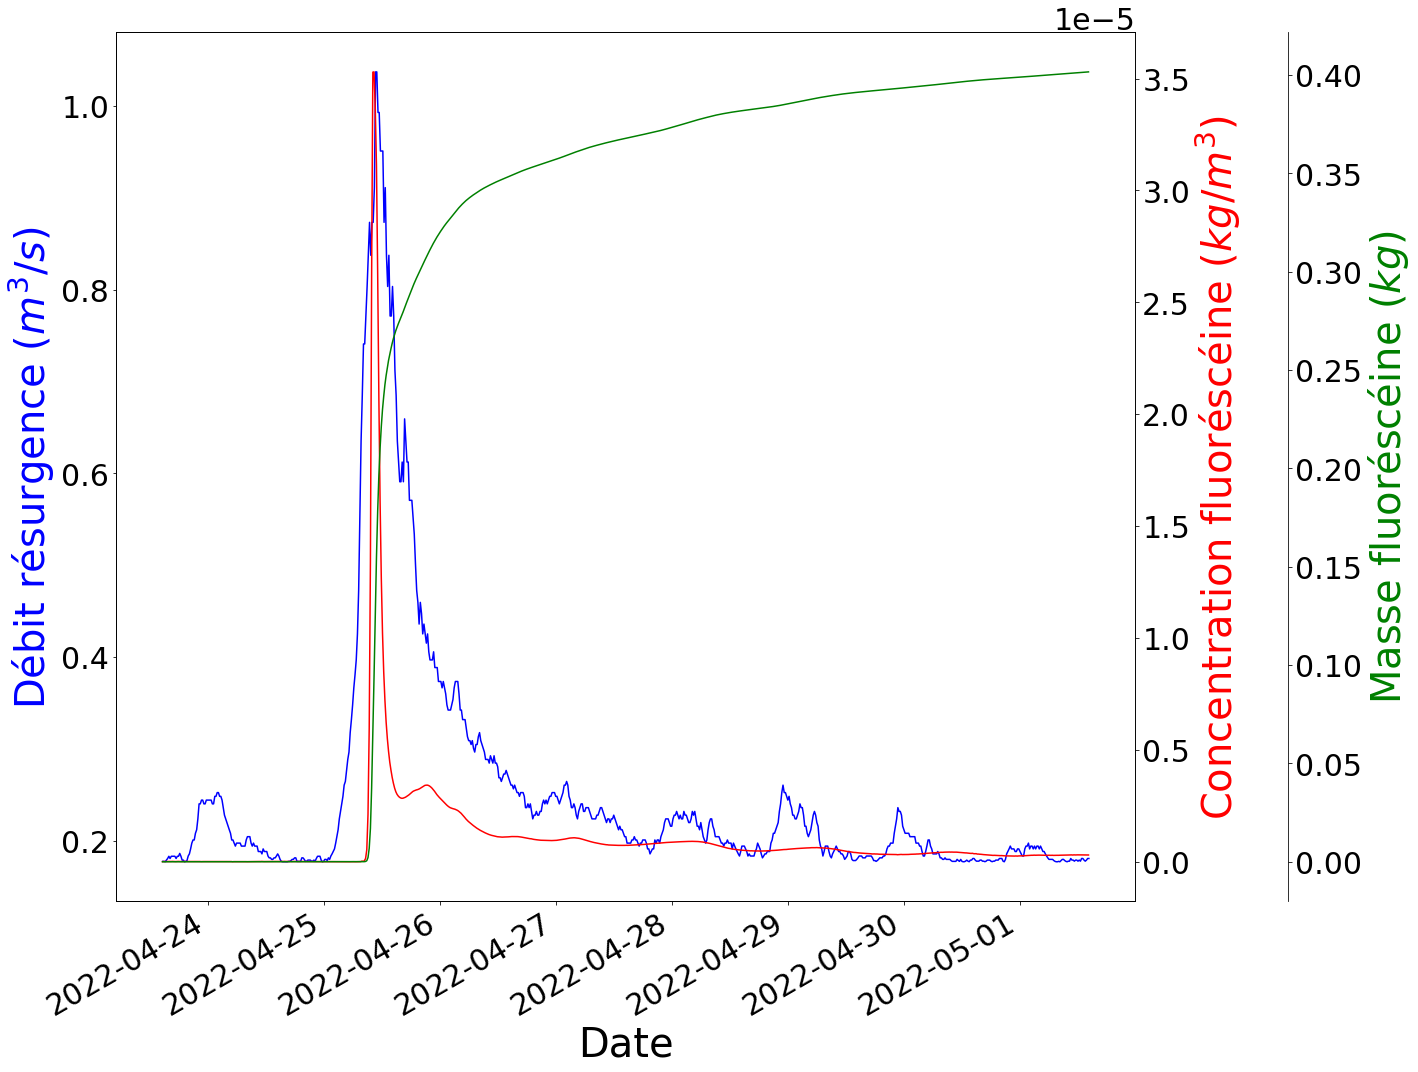

In [8]:
fig=plt.figure()
ax=plt.gca()

ax1=ax.twinx()
ax2=ax.twinx()
ax2.spines.right.set_position(("axes", 1.15))

Q.plot(ax=ax,y="Débit résurgence (m3/s)",c='b',legend=False)
F.plot(ax=ax1,y="Concentration(kg/m3)",c='r',legend=False)
F.plot(ax=ax2,y="Masse (kg)",c='g',legend=False)

ax.yaxis.label.set_color('b')
ax1.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('g')

ax.set_ylabel(r'Débit résurgence ($m^3/s$)')
ax1.set_ylabel(r'Concentration fluoréscéine ($kg/m^3$)')
ax2.set_ylabel(r'Masse fluoréscéine ($kg$)')

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')

plt.tight_layout()
plt.savefig('figure1.jpg')

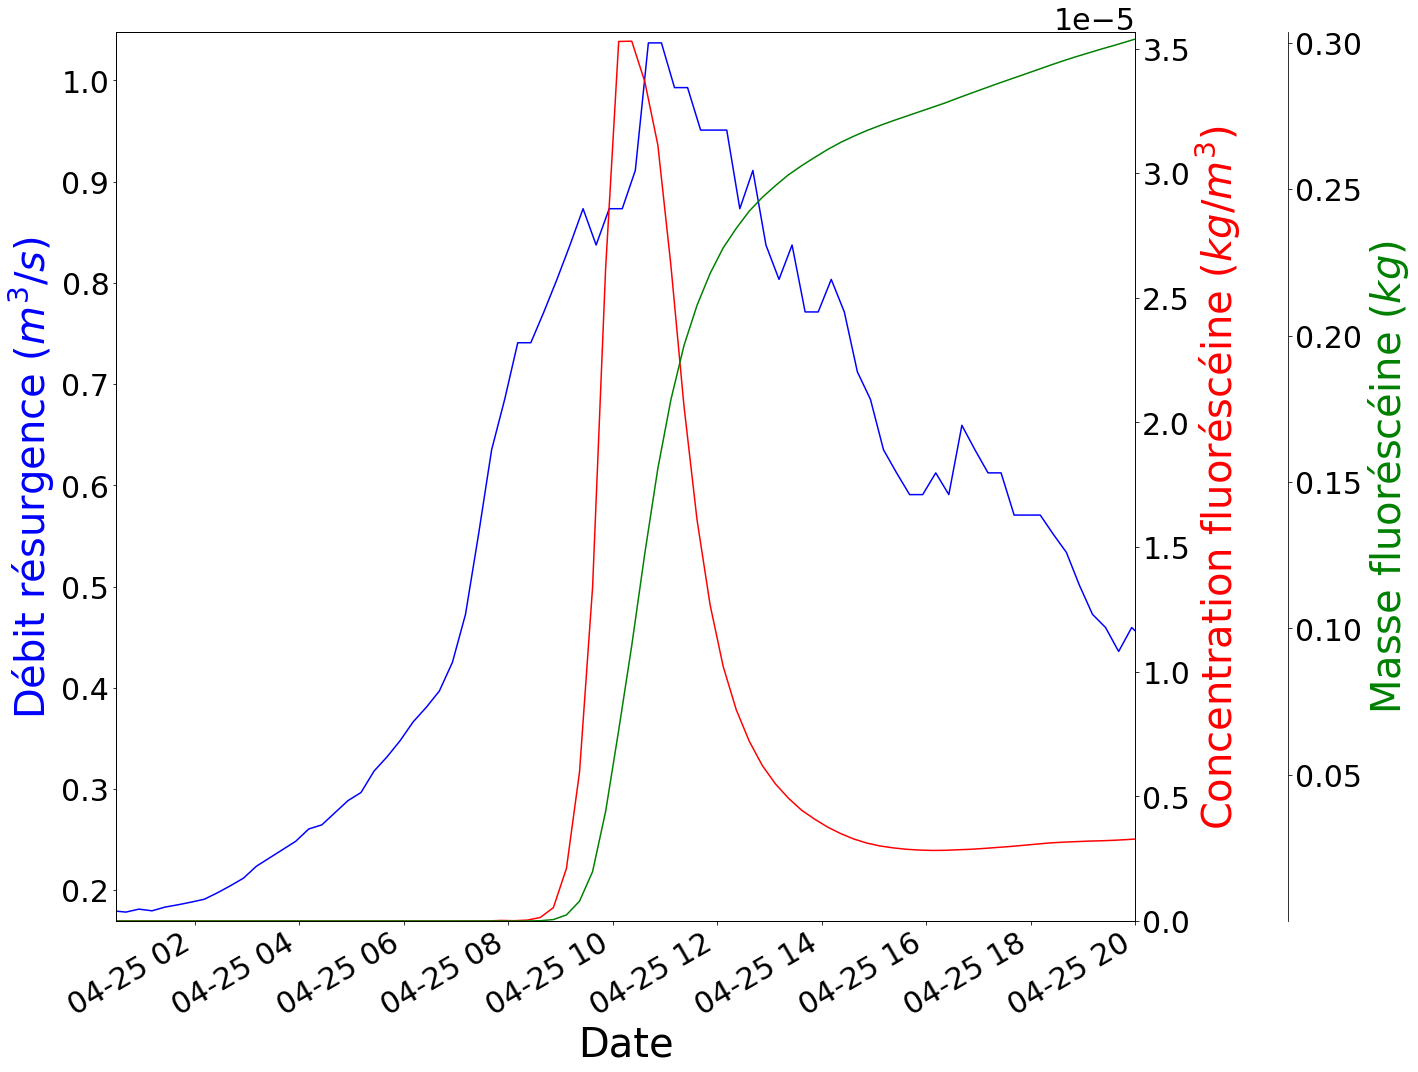

In [9]:
xlim=[datetime.datetime(2022, 4, 25,0,30,0), datetime.datetime(2022, 4,25,20,0,0)]

fig=plt.figure()
ax=plt.gca()

ax1=ax.twinx()
ax2=ax.twinx()
ax2.spines.right.set_position(("axes", 1.15))

Q.plot(ax=ax,y="Débit résurgence (m3/s)",c='b',legend=False)
F.plot(ax=ax1,y="Concentration(kg/m3)",c='r',legend=False)
F.plot(ax=ax2,y="Masse (kg)",c='g',legend=False)

ax.yaxis.label.set_color('b')
ax1.yaxis.label.set_color('r')
ax2.yaxis.label.set_color('g')

ax.set_ylabel(r'Débit résurgence ($m^3/s$)')
ax1.set_ylabel(r'Concentration fluoréscéine ($kg/m^3$)')
ax2.set_ylabel(r'Masse fluoréscéine ($kg$)')


ax.set_xlim(xlim)
ax.set_ylim( Q[xlim[0]:xlim[1]]['Débit résurgence (m3/s)'].min()*0.95, Q[xlim[0]:xlim[1]]['Débit résurgence (m3/s)'].max()*1.01)
ax1.set_ylim( F[xlim[0]:xlim[1]]['Concentration(kg/m3)'].min()*0.95, F[xlim[0]:xlim[1]]['Concentration(kg/m3)'].max()*1.01)
ax2.set_ylim( F[xlim[0]:xlim[1]]['Masse (kg)'].min()*0.95, F[xlim[0]:xlim[1]]['Masse (kg)'].max()*1.01)

fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right', which='major')
plt.tight_layout()
plt.savefig('figure2_pic.jpg')


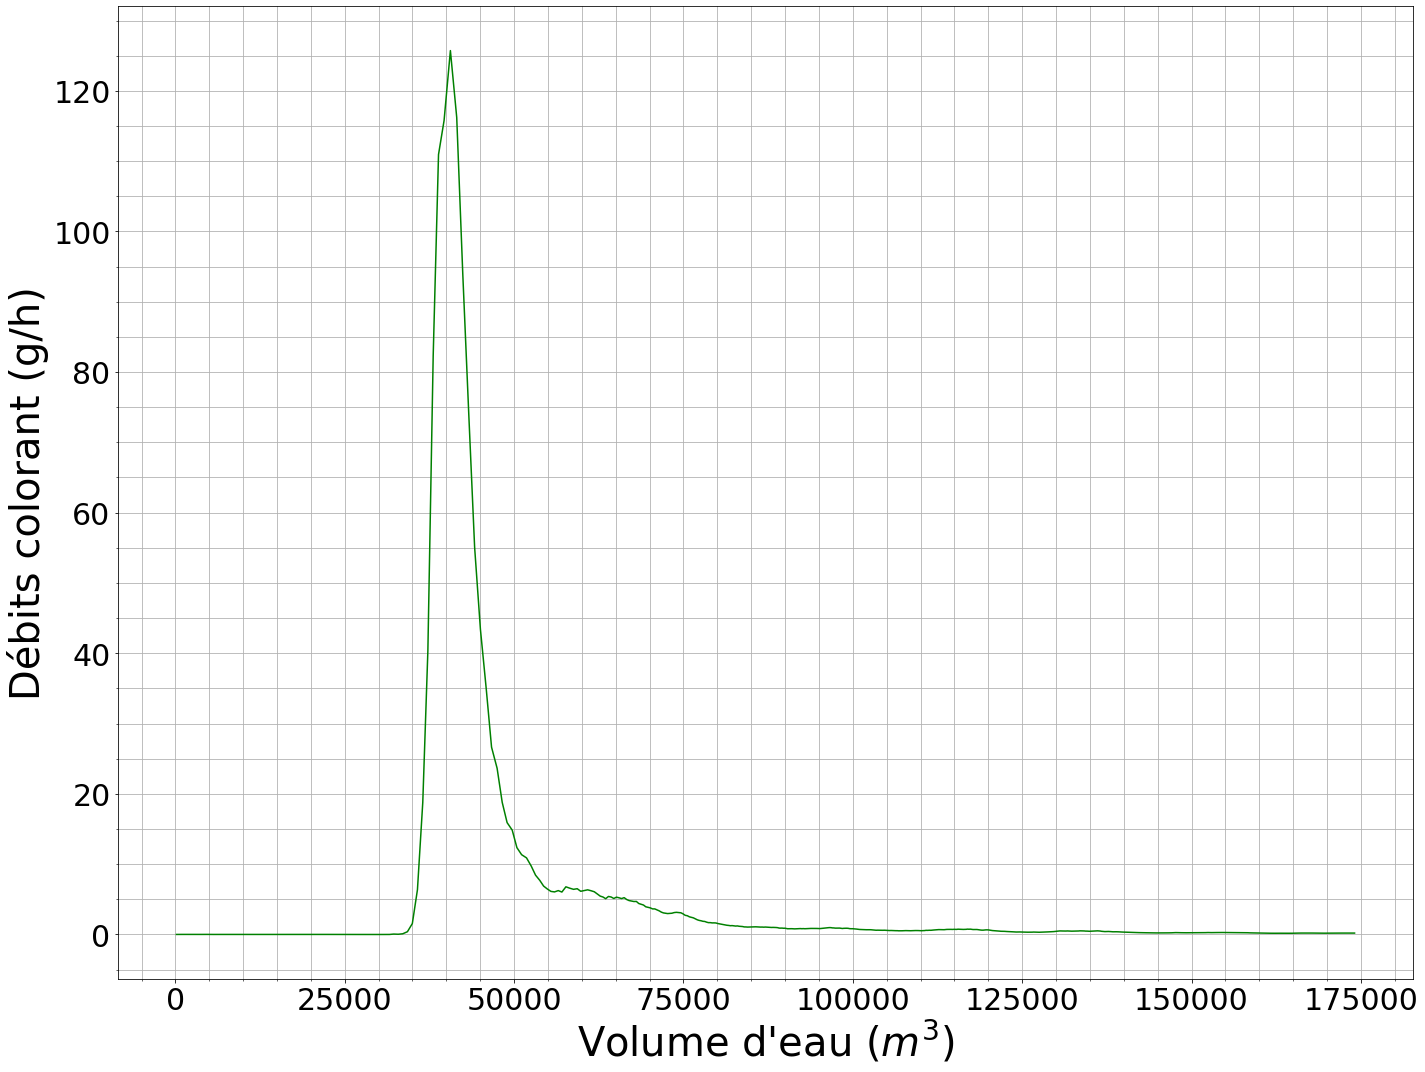

In [36]:
F['Débits colorant (g/h)']=F['Concentration(kg/m3)'].values*10**3*Q['Débit résurgence (m3/s)'].values*3600 # Débits de colorant en g/h
plt.figure()
ax=plt.gca()
ax.plot(Q['Volume eau (m3)'],F['Débits colorant (g/h)'],c='green')
# plt.grid()
plt.ylabel('Débits colorant (g/h)')
plt.xlabel(r"Volume d'eau ($m^3$)")
ax.minorticks_on()
ax.grid(True, which='both')
plt.tight_layout()
plt.savefig('Volume_eau_pousse.jpg')


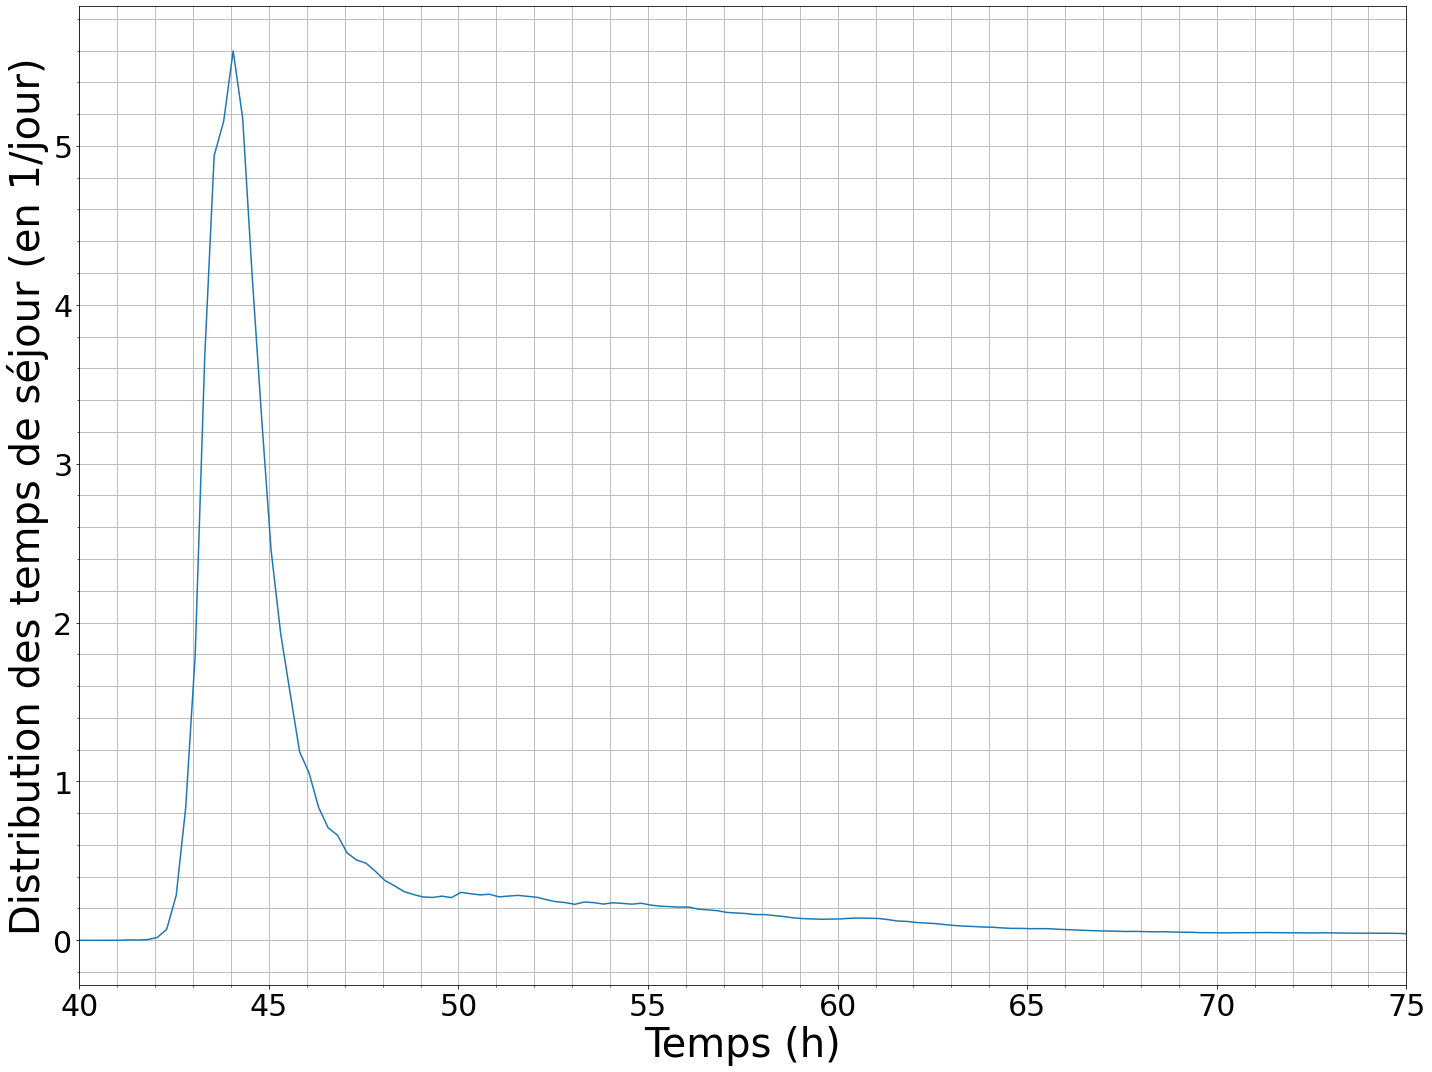

In [35]:
## temps de séjours
h= datetime.datetime(2022, 5,1,14,15,0)-datetime.datetime(2022, 4, 23,14,30,0)
H=h.days*24+h.seconds/3600
time=np.linspace(0,H,len(Q['Débit résurgence (m3/s)']))


E=Q['Débit résurgence (m3/s)'].values*24*3600*F['Concentration Fluo (kg/m3)'].values/M
plt.figure()
ax=plt.gca()
plt.plot(time,E)
plt.xlabel('Temps (h)')
plt.ylabel(r"Distribution des temps de séjour (en 1/jour)")
plt.xlim([40,75])
ax.minorticks_on()
ax.grid(True, which='both')
plt.tight_layout()
plt.savefig('Temps_sejour.jpg')
